## Соревнования по Титаник на Kaggle
Пример кода для отправки решения в соревновании Kaggle - https://www.kaggle.com/c/titanic/data



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from google.colab import files
%matplotlib inline

## Устанавливаем Kaggle API

In [ ]:
!pip install kaggle

Загружаем токен аутентификации

In [ ]:
file = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!ls

kaggle.json  sample_data


In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

# Загружаем данные с сайта Kaggle

In [ ]:
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 22.4MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 26.8MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.64MB/s]


In [ ]:
!ls

gender_submission.csv  sample_data  test.csv  train.csv


## Проверяем данные

In [ ]:
!head train.csv

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
6,0,3,"Moran, Mr. James",male,,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S


In [ ]:
!head test.csv

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7,,S
894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,,Q
895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,,S
897,3,"Svensson, Mr. Johan Cervin",male,14,0,0,7538,9.225,,S
898,3,"Connolly, Miss. Kate",female,30,0,0,330972,7.6292,,Q
899,2,"Caldwell, Mr. Albert Francis",male,26,1,1,248738,29,,S
900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18,0,0,2657,7.2292,,C


In [ ]:
!head gender_submission.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## Подготовка данных для обучения сети

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
print(train.isna().sum())
print(test.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [ ]:
print(train.corr()) 

             PassengerId  Survived    Pclass  ...     SibSp     Parch      Fare
PassengerId     1.000000 -0.005007 -0.035144  ... -0.057527 -0.001652  0.012658
Survived       -0.005007  1.000000 -0.338481  ... -0.035322  0.081629  0.257307
Pclass         -0.035144 -0.338481  1.000000  ...  0.083081  0.018443 -0.549500
Age             0.036847 -0.077221 -0.369226  ... -0.308247 -0.189119  0.096067
SibSp          -0.057527 -0.035322  0.083081  ...  1.000000  0.414838  0.159651
Parch          -0.001652  0.081629  0.018443  ...  0.414838  1.000000  0.216225
Fare            0.012658  0.257307 -0.549500  ...  0.159651  0.216225  1.000000

[7 rows x 7 columns]


In [ ]:
train['Embarked'] = train['Embarked'].fillna('S')
train['Family_size'] = train['SibSp']+train['Parch']+1
train['Fare_class'] = pd.qcut(train.Fare, 5, labels=False)

In [ ]:
test['Fare'] = test['Fare'].fillna(test.Fare.mean())
test['Family_size'] = test['SibSp']+test['Parch']+1
test['Fare_class'] = pd.qcut(test.Fare, 5, labels=False)

In [ ]:
print(train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [ ]:
print(train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [ ]:
print(train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


In [ ]:
print(train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False))

   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


In [ ]:
print(train[["Family_size", "Survived"]].groupby(['Family_size'], as_index=False).mean().sort_values(by='Survived', ascending=False))

   Family_size  Survived
3            4  0.724138
2            3  0.578431
1            2  0.552795
6            7  0.333333
0            1  0.303538
4            5  0.200000
5            6  0.136364
7            8  0.000000
8           11  0.000000


In [ ]:
print(train[["Fare_class", "Survived"]].groupby(['Fare_class'], as_index=False).mean().sort_values(by='Survived', ascending=False))

   Fare_class  Survived
4           4  0.642045
3           3  0.444444
2           2  0.424419
0           0  0.217877
1           1  0.201087


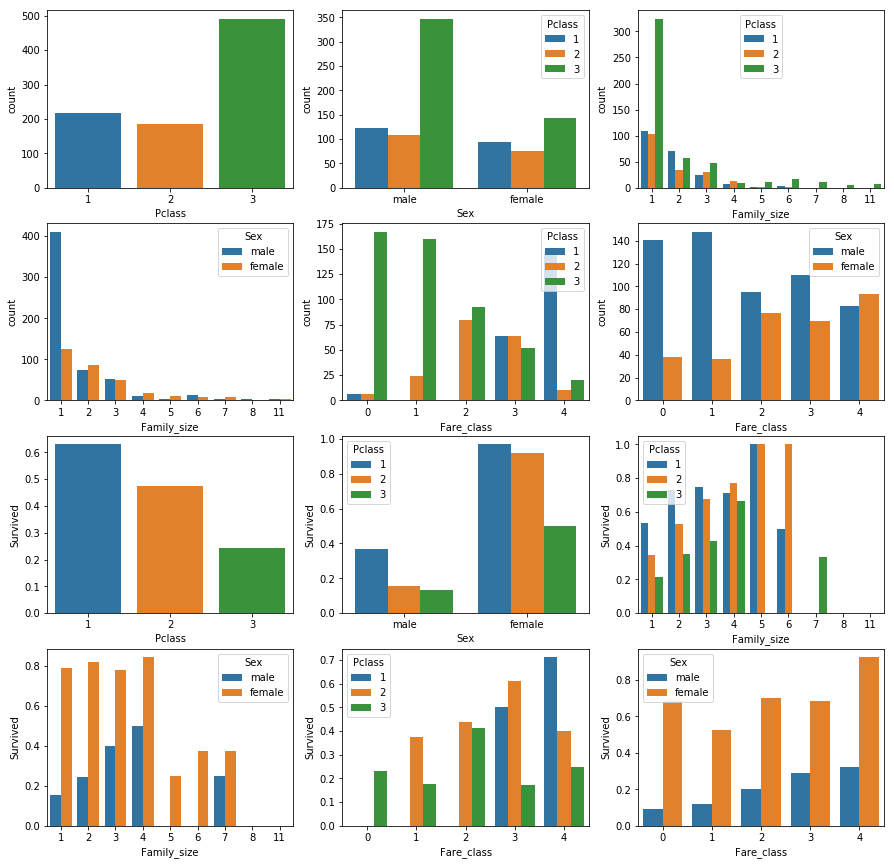

In [ ]:
f, axes = plt.subplots(4, 3, figsize=(15, 15))
sns.catplot('Pclass',data=train,kind='count',ax=axes[0,0]) #Number of people per ticket class
sns.catplot('Sex',data=train,hue='Pclass',kind='count',ax=axes[0,1]) #Number of people per sex, further divided per ticket class
sns.catplot('Family_size',data=train,hue='Pclass',kind='count',ax=axes[0,2]) #Number of people per family size, further divided per ticket class
sns.catplot('Family_size',data=train,hue='Sex',kind='count',ax=axes[1,0]) #Number of people per family size, further divided per sex
sns.catplot('Fare_class',data=train,hue='Pclass',kind='count',ax=axes[1,1]) #Number of people per fare class, further divided per ticket class
sns.catplot('Fare_class',data=train,hue='Sex',kind='count',ax=axes[1,2]) #Number of people per fare class, further divided per sex
sns.catplot(x='Pclass',y='Survived',data=train,kind='bar',ci=None,ax=axes[2,0]) #Number of survived people per ticket class
sns.catplot(x='Sex',y='Survived',data=train,hue='Pclass',kind='bar',ci=None,ax=axes[2,1]) #Number of survived people per sex, further divided per ticket class
sns.catplot(x='Family_size',y='Survived',data=train,hue='Pclass',kind='bar',ci=None,ax=axes[2,2]) #Number of survived people per family size, further divided per ticket class
sns.catplot(x='Family_size',y='Survived',data=train,hue='Sex',kind='bar',ci=None,ax=axes[3,0]) #Number of survived people per family size, further divided per sex
sns.catplot(x='Fare_class',y='Survived',data=train,hue='Pclass',kind='bar',ci=None,ax=axes[3,1]) #Number of survived people per fare class, further divided per ticket class
sns.catplot(x='Fare_class',y='Survived',data=train,hue='Sex',kind='bar',ci=None,ax=axes[3,2]) #Number of survived people per fare class, further divided per sex
for abc in range(2,14,1):
    plt.close(abc)

In [ ]:
# Converting sex and embarked to dummy variables
sex_type = {"male":0,"female":1}
train["Sex"] = train["Sex"].map(sex_type)
test["Sex"] = test["Sex"].map(sex_type)
embarked_loc = {"S":0,"C":1,"Q":2}
train["Embarked"] = train["Embarked"].map(embarked_loc)
test["Embarked"] = test["Embarked"].map(embarked_loc)

подготавливаем данные обучения

In [ ]:
X_train = train.drop(["Survived","Fare","Cabin","Age","PassengerId","Name","Ticket"], axis=1)
Y_train = train["Survived"]
X_test = test.drop(["PassengerId","Name","Age","Ticket","Fare","Cabin"],axis=1)

# Обучаем

In [ ]:
random_forest = RandomForestClassifier(n_estimators=50)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

0.856341189674523

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'Age distribution test set')

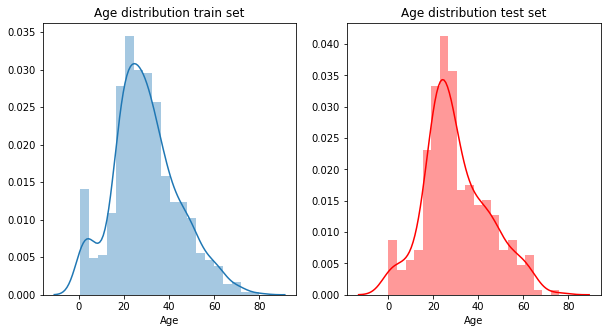

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.distplot(train["Age"],hist=True,bins=20,ax=axes[0]) #approximately normal distribution, it can be used to fill the NaNs
axes[0].set_title('Age distribution train set')
ax2 = sns.distplot(test["Age"],hist=True,bins=20,ax=axes[1], color="r") #approximately normal distribution, it can be used to fill the NaNs
axes[1].set_title('Age distribution test set')

In [ ]:
# Filling the Age NaNs by sampling from the two normal distributions
meanAge_train, stdAge_train = train["Age"].mean(), train["Age"].std() #mean and standard deviation for the column Age, train set
nullAge_train = train["Age"].isnull() #get the indeces where NaNs are present in the Age column
sampAge_norm_dist_train = np.random.normal(meanAge_train, stdAge_train, nullAge_train.sum())
for ii in range(0,len(sampAge_norm_dist_train)): #checking for eventual age values below zero
    if sampAge_norm_dist_train[ii] < 0:
        sampAge_norm_dist_train[ii] = np.random.normal(meanAge_train, stdAge_train, 1)
train["Age"].loc[nullAge_train] = sampAge_norm_dist_train #fill in the NaNs with the samples values
        

meanAge_test, stdAge_test = test["Age"].mean(), test["Age"].std() #same procedure as for the train set
nullAge_test = test["Age"].isnull()
sampAge_norm_dist_test = np.random.normal(meanAge_test, stdAge_test, nullAge_test.sum())
for jj in range(0,len(sampAge_norm_dist_test)):
    if sampAge_norm_dist_test[jj] < 0:
        sampAge_norm_dist_test[jj] = np.random.normal(meanAge_test, stdAge_test, 1)
test["Age"].loc[nullAge_test] = sampAge_norm_dist_test

# Now both train and test set should have no NaNs in the Age column
print(train.isna().sum()) 
print(test.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Family_size      0
Fare_class       0
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Family_size      0
Fare_class       0
dtype: int64


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Text(0.5, 1.0, 'Age distribution test set after NaNs filling')

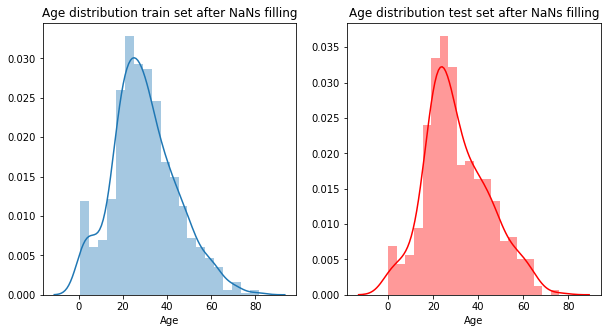

In [ ]:
# Plotting Age distribution after NaNs filling
f, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.distplot(train["Age"],hist=True,bins=20,ax=axes[0]) #approximately normal distribution, it can be used to fill the NaNs
axes[0].set_title('Age distribution train set after NaNs filling')
ax2 = sns.distplot(test["Age"],hist=True,bins=20,ax=axes[1], color="r") #approximately normal distribution, it can be used to fill the NaNs
axes[1].set_title('Age distribution test set after NaNs filling')

In [ ]:
# Binning Age into discrete intervals
age_threshold = [0,18,35,50,65,train["Age"].max()] #should make sense to divide into minors, young adults, adults, old adults, elderly
age_label = [1,2,3,4,5] #new label for the age bins
train["Age_discrete"] = pd.cut(train["Age"], age_threshold, labels=age_label, include_lowest = True) #new column that will be used in the classification
test["Age_discrete"] = pd.cut(test["Age"], age_threshold, labels=age_label, include_lowest = True) #same procedure for the test dataset

In [ ]:
# Creating input train and test structures with Age
X_train_w_age = train.drop(["Survived","Fare","Cabin","Age","PassengerId","Name","Ticket"], axis=1)
X_test_w_age = test.drop(["PassengerId","Name","Age","Ticket","Fare","Cabin"],axis=1)

# Random forest algorigthm with 100 estimations, including Age as variable
random_forest_w_age = RandomForestClassifier(n_estimators=100)
random_forest_w_age.fit(X_train_w_age, Y_train)

Y_prediction_w_age = random_forest_w_age.predict(X_test_w_age)

random_forest_w_age.score(X_train_w_age, Y_train)

0.8956228956228957

Text(0.5, 0, 'Relative Importance')

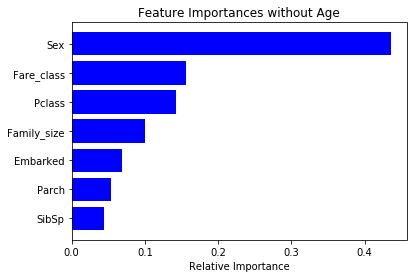

In [ ]:
# Calculating the importance of each variable in both models
features= X_train.columns
importances = random_forest.feature_importances_
indices = np.argsort(importances)
plt.figure(1)
plt.title('Feature Importances without Age')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

Text(0.5, 0, 'Relative Importance')

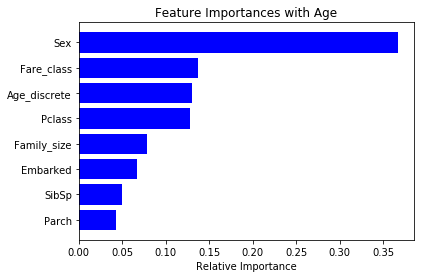

In [ ]:
features_w_age = X_train_w_age.columns
importances_w_age = random_forest_w_age.feature_importances_
indices_w_age = np.argsort(importances_w_age)
plt.figure(1)
plt.title('Feature Importances with Age')
plt.barh(range(len(indices_w_age)), importances_w_age[indices_w_age], color='b', align='center')
plt.yticks(range(len(indices_w_age)), [features_w_age[i] for i in indices_w_age])
plt.xlabel('Relative Importance')

## сохраняем результат

In [ ]:
submission_titanic = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':Y_prediction_w_age})
submission_titanic.to_csv("titanic-submission.csv", index=False)

In [ ]:
submission_titanic_without_age = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':Y_prediction})
submission_titanic_without_age.to_csv('Titanic_submission_2.csv',index=False)

In [ ]:
from google.colab import files
files.download("Titanic_submission_2.csv")

## Отправка результата

In [ ]:
!kaggle competitions submit -c titanic -m "Submition from Colab" -f titanic-submission.csv

100% 2.77k/2.77k [00:03<00:00, 752B/s]
Successfully submitted to Titanic: Machine Learning from Disaster

In [ ]:
!kaggle competitions submit -c titanic -m "Submition from Colab" -f Titanic_submission_2.csv

100% 2.77k/2.77k [00:03<00:00, 723B/s]
Successfully submitted to Titanic: Machine Learning from Disaster